In [7]:
import pandas as pd
import glob
from StringIO import StringIO
import matplotlib.pyplot as plt
import os
import matplotlib
import sys
from datetime import datetime, timedelta
from time import sleep, time
import numpy as np
import pandas.plotting._converter as pandacnv
import ROOT
from ROOT import TH1D, TCanvas, TNtuple, kBlue, kRed, kBlack, TTree, TFile
from ROOT import addressof
from array import array
pandacnv.register()


In [2]:
#kNBITS = 16
#nfails={}
#for k in range(1<<(kNBITS)):
#    cnt = 0
#    for i in range(kNBITS):
#        cnt += int(k>>i)%2
#    nfails[k] = cnt
def nfails(k,NBITS = 16):
    cnt = 0
    for i in range(NBITS):
        cnt += int(k>>i)%2
    return cnt

nfails((~0xDF&0xFF))


1

In [3]:
names = ['time','lfsrTMR','B0','B1','B2','B3']
#f = open("SecondRunAna/cpld_data/cpld_data_2022_09_15_135543_00006.dat")
fnames = glob.glob('SecondRunAna/cpld_data/4CPLD/data_run/cpld_data_*.dat')

dfs = []
for fn in fnames:
    try :
        f = open(fn)
        nf = f.read().replace('*','').replace(' #',',')
        dfs.append(pd.read_csv(StringIO(nf),sep=',',header=None, names=names, error_bad_lines=False,parse_dates=['time']))
    except:
        print fn
        
        #print(nf)

df = pd.concat(dfs, ignore_index=True)
#df = pd.read_csv(StringIO(nf),sep=',',header=None, names=names, error_bad_lines=False,parse_dates=['time'])
#df['time'] = df['time'].astype('float64').astype('datetime64[s]') + timedelta(hours=2)
#df.index=df['time']
df = df[~pd.isnull(df['B0'])]
df = df[~pd.isnull(df['B1'])]
df = df[~pd.isnull(df['B2'])]
df = df[~pd.isnull(df['B3'])]
df['time'] = df['time'].astype('float64').astype('datetime64[s]') + timedelta(hours=2)
df = df.sort_values(by='time')

In [4]:
# df = df[(df['time']>'2022-09-18 08:40:53')&(df['time']<'2022-09-18 09:06:13')]
# len(df)
# print ("{0:x}".format(int((~int('fc00',16))&0xff00)>>8))
len(df)

1055636

In [4]:
Nbits=32
rows = zip(df['B0'],df['B1'],df['B2'],df['B3'],df['time'])
#rows = zip(df[(df['time']>'2022-09-18 09:05:53')&(df['time']<'2022-09-18 09:06:13')]['B0'],\
#           df[(df['time']>'2022-09-18 09:05:53')&(df['time']<'2022-09-18 09:06:13')]['B1'],\
#           df[(df['time']>'2022-09-18 09:05:53')&(df['time']<'2022-09-18 09:06:13')]['B2'],\
#           df[(df['time']>'2022-09-18 09:05:53')&(df['time']<'2022-09-18 09:06:13')]['B3'],\
#           df[(df['time']>'2022-09-18 09:05:53')&(df['time']<'2022-09-18 09:06:13')]['time'])

b0n=['nan']*len(rows)
b1n=['nan']*len(rows)
b2n=['nan']*len(rows)
b3n=['nan']*len(rows)
bitsn= [[0 for i in range (len(rows))] for j in range (Nbits)]
bitsnP = [[0 for i in range (len(rows))] for j in range (Nbits)]

bt=[0]*len(rows)
btI=[0]*len(rows)
count=[0]*len(rows)
print len(rows)
cnt = 0
bias = 0
bits=[0]*Nbits
bitsp=[0]*Nbits
bitsI=[0]*Nbits
bitsPI=[0]*Nbits

for (b0, b1, b2, b3, time) in rows:
    try:
        b0n[cnt] = nfails(int((~int(b0,16))&0xFF00)>>8)
        b1n[cnt] = nfails(int((~int(b1,16))&0xFF00)>>8)
        b2n[cnt] = nfails(int((~int(b2,16))&0xFF00)>>8)
        b3n[cnt] = nfails(int((~int(b3,16))&0xFF00)>>8)
        bt[cnt] = b0n[cnt] + b1n[cnt] + b2n[cnt] + b3n[cnt]
        if cnt>0 and bt[cnt] == 0 and  bt[cnt-1] !=0 :
            bias = btI[cnt-1]
        
        btI[cnt] = bt[cnt] + bias
        
        if  cnt>0 and btI[cnt]<btI[cnt-1]:
            btI[cnt] = btI[cnt-1]
        for k in range(8):
            bits[k] = ((int((~int(b0,16))&0xFF00)>>8)>>k)&1
            bits[k+8] = ((int((~int(b1,16))&0xFF00)>>8)>>k)&1
            bits[k+8*2] = ((int((~int(b2,16))&0xFF00)>>8)>>k)&1
            bits[k+8*3] = ((int((~int(b3,16))&0xFF00)>>8)>>k)&1
#             if cnt==0:
#                 continue
            #bit change error counting
            if bitsp[k]==0 and bits[k]==1:
                bitsI[k] +=1
            if bitsp[k+8]==0 and bits[k+8]==1:
                bitsI[k+8] +=1
            if bitsp[k+8*2]==0 and bits[k+8*2]==1:
                bitsI[k+8*2] +=1
            if bitsp[k+8*3]==0 and bits[k+8*3]==1:
                bitsI[k+8*3] +=1
            
            bitsn[k][cnt] = bitsI[k]
            bitsn[k+8][cnt] = bitsI[k+8]
            bitsn[k+8*2][cnt] = bitsI[k+8*2]
            bitsn[k+8*3][cnt] = bitsI[k+8*3]
            
            ####################
            #periodic errors counting.
            if cnt>=3 and bitsn[k][cnt]==bitsn[k][cnt-1]+1 \
                    and bitsn[k][cnt-1]==bitsn[k][cnt-2] \
                    and bitsn[k][cnt-2]==bitsn[k][cnt-3]+1:
                bitsPI[k] +=1
            if cnt>=3 and bitsn[k+8][cnt]==bitsn[k+8][cnt-1]+1 \
                    and bitsn[k+8][cnt-1]==bitsn[k+8][cnt-2] \
                    and bitsn[k+8][cnt-2]==bitsn[k+8][cnt-3]+1:
                bitsPI[k+8] +=1
            if cnt>=3 and bitsn[k+8*2][cnt]==bitsn[k+8*2][cnt-1]+1 \
                    and bitsn[k+8*2][cnt-1]==bitsn[k+8*2][cnt-2] \
                    and bitsn[k+8*2][cnt-2]==bitsn[k+8*2][cnt-3]+1:
                bitsPI[k+8*2] +=1
            if cnt>=3 and bitsn[k+8*3][cnt]==bitsn[k+8*3][cnt-1]+1 \
                    and bitsn[k+8*3][cnt-1]==bitsn[k+8*3][cnt-2] \
                    and bitsn[k+8*3][cnt-2]==bitsn[k+8*3][cnt-3]+1:
                bitsPI[k+8*3] +=1
                
            bitsnP[k][cnt] = bitsPI[k]
            bitsnP[k+8][cnt] = bitsPI[k+8]
            bitsnP[k+8*2][cnt] = bitsPI[k+8*2]
            bitsnP[k+8*3][cnt] = bitsPI[k+8*3]
            ###############
            
#DEBUG PURPOSE            
#         bitsr=0
#         bitsIr=0
#         bitspr=0
#         bitsnr=0

#         for k in range(Nbits):
#             bitsIr += bitsI[k]<<k
#             bitspr += bits[k]<<k
#             bitsnr += bitsn[k][cnt]<<k
            
#         print ("b0/cnt/bitsp/bitsI/bitsn ::::: {0:x}/{1}/{2:x}/{3:x}/{4:x}".format(int((~int(b0,16))&0xFF00)>>8,\
#                                                                                    cnt,bitspr,bitsIr,bitsnr))
#         sleep(0.01)
#######################        
        count[cnt] = cnt
      
    except:
        btI[cnt] = btI[cnt-1]
        for k in range(Nbits):
            bitsn[k][cnt] = bitsn[k][cnt-1]
            bitsnP[k][cnt] = bitsnP[k][cnt-1]
    cnt +=1
    bitsp=bits[:]
       
        #print (b0, b1, b2, b3)
        #print (b0, b1, b2, b3)
        
df['B0_nfails'] = b0n
df['B1_nfails'] = b1n
df['B2_nfails'] = b2n
df['B3_nfails'] = b3n
df['total_fails'] = bt
df['total_I'] = btI
df['count'] = count

for k in range(Nbits):
    df["bitn"+str(k)]=bitsn[k][:]
    df["bitnP"+str(k)]=bitsnP[k][:]
    
#df[df['B0_nfails']>=2]
# df[df['B1_nfails']>=2]
# df[df['B2_nfails']>=2]
# df[df['B3_nfails']>=2]

# df = df[df['B0_nfails']!='nan']
# df = df[df['B1_nfails']!='nan']
# df = df[df['B2_nfails']!='nan']
# df = df[df['B3_nfails']!='nan']
len(df)

1055636


1055636

In [35]:
# #df[(df['time']>'2022-09-18 09:05:53')&(df['time']<'2022-09-18 09:06:13')]
# #df[(df['time']>'2022-09-18 09:00:53')&(df['time']<'2022-09-18 09:06:13')]['bitn1']
# print 'ok'
# len(df)
# plt.savefig('SecondRunAna/cpld_fails_bits.png', bbox_inches='tight')
for k in range(Nbits):
    print("bit: {0}, errors: {1}".format(k,df['bitn' + str(k)].tail(1) ))


bit: 0, errors: 651029    1001
Name: bitn0, dtype: int64
bit: 1, errors: 651029    1896
Name: bitn1, dtype: int64
bit: 2, errors: 651029    2398
Name: bitn2, dtype: int64
bit: 3, errors: 651029    1482
Name: bitn3, dtype: int64
bit: 4, errors: 651029    1107
Name: bitn4, dtype: int64
bit: 5, errors: 651029    607
Name: bitn5, dtype: int64
bit: 6, errors: 651029    3066
Name: bitn6, dtype: int64
bit: 7, errors: 651029    801
Name: bitn7, dtype: int64
bit: 8, errors: 651029    1308
Name: bitn8, dtype: int64
bit: 9, errors: 651029    4295
Name: bitn9, dtype: int64
bit: 10, errors: 651029    2490
Name: bitn10, dtype: int64
bit: 11, errors: 651029    61
Name: bitn11, dtype: int64
bit: 12, errors: 651029    1423
Name: bitn12, dtype: int64
bit: 13, errors: 651029    1272
Name: bitn13, dtype: int64
bit: 14, errors: 651029    811
Name: bitn14, dtype: int64
bit: 15, errors: 651029    2672
Name: bitn15, dtype: int64
bit: 16, errors: 651029    725
Name: bitn16, dtype: int64
bit: 17, errors: 651029

In [38]:
darr = array('i',Nbits*[0])
darrP = array('i',Nbits*[0])
tstmp = array('d',[0])

ofile=TFile("cpld_data_second_run.root",'recreate')
tr=TTree("tr",'cpld data')
tr.Branch("t",tstmp,"t/D") 
tr.Branch("bit",darr,"bit["+str(Nbits)+"]/I")
tr.Branch("bitP",darrP,"bitP["+str(Nbits)+"]/I")

rows = []
for k in range(Nbits):
    rows.append(df['bitn'+str(k)])
for k in range(Nbits):
    rows.append(df['bitnP'+str(k)])

rows.append(df['time'])

rows = zip(*rows)

for val in rows:
    b = val[0:32]
    bP = val[32:-1]
    t = val[-1]
    for k in range(Nbits):
        darr[k] = b[k]
        darrP[k] = bP[k]
    tstmp[0] = (t - datetime(1970, 1, 1)).total_seconds()
    tr.Fill()
ofile.Write()
ofile.Close()

KeyError: 'bitn32'

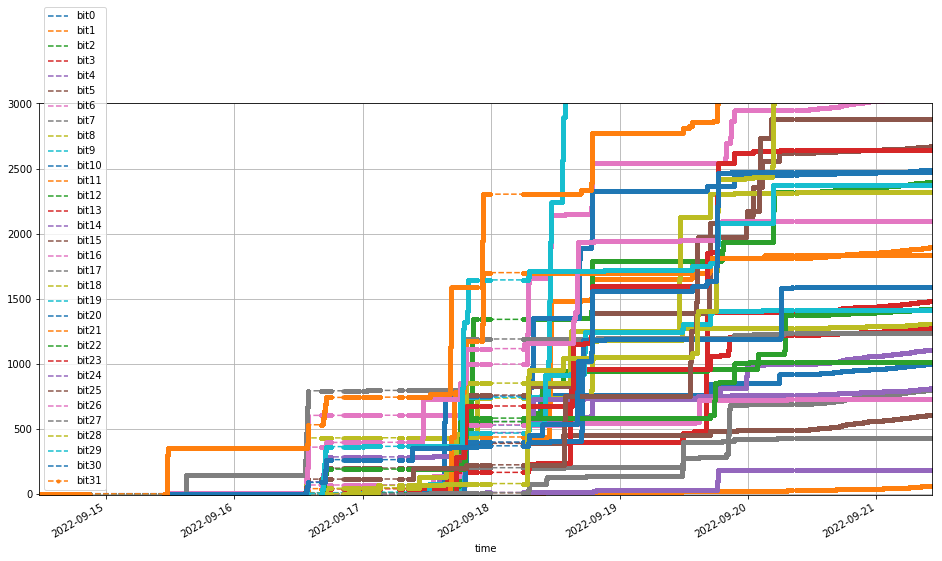

In [5]:
ymax = 5000
ymin = -10
#ax=plt.figure(figsize=(12, 8), dpi=150)
#ax = df[(df['time']>'2022-09-16 13:12:25')&(df['time']<'2022-09-16 13:15:00')].plot(x='time',y='B0_nfails',grid=True, figsize=(9,6),marker='.',linestyle='--')
#ax = df.plot(x='time',y='total_I',grid=True, figsize=(9,6), ylim=(-10,10000),marker='.',linestyle='--')
#ax = df.plot(x='time',y='total_fails',grid=True, figsize=(9,6), ylim=(-1,40),marker='.',linestyle='--')
#ax = df.plot(x='time',y='bitn0',grid=True, figsize=(9,6), ylim=(-10,4000),marker='.',linestyle='--')
#ax = df.plot(x='time',y='bitn0', label='bit0', color='b', grid=True, ylim=(ymin,ymax),marker='.',linestyle='--')
ax = df.plot(x='time',y='bitn0', label='bit0', grid=True, ylim=(ymin,ymax),marker='.',linestyle='--',figsize=(16, 8))
for k in range(Nbits-1):
    df.plot(ax=ax, x='time', y='bitn' + str(k+1), grid=True, marker='.',linestyle='--', label='bit'+str(k+1))

ax.set_xlabel("date")
ax.set_ylabel("Number of fails")
plt.legend()
plt.show()
plt.savefig('SecondRunAna/cpld_fails_bits.png', bbox_inches='tight')

In [ ]:
#df[(df['time']<'2022-06-12 00:30:00')&(df['time']>'2022-06-12 00:00:00')].plot(x='time',y='IDC',grid=True, figsize=(9,6), ylim=(0,0.9),marker='.',linestyle='--')
#df.plot(x='time',y='IDC',grid=True, figsize=(9,6), ylim=(0,1.6),marker='.',linestyle='--')
#df[(df['time']<'2022-05-29 13:45:00')&(df['time']>'2022-05-29 13:40:00')].plot(x='time',y='IDC',grid=True, figsize=(9,6), ylim=(0,1.6),marker='.',linestyle='--')
df[(df['time']>'2022-09-17 17:32:00')&(df['time']<'2022-09-17 17:37:00')].plot(x='time',y='IDC',grid=True, figsize=(9,6), ylim=(0,1.6),marker='.',linestyle='--')
plt.ylabel('Idc A')
#plt.savefig('FirstRunAna/current_fail_202206_12_all.svg', bbox_inches='tight')
#plt.savefig('SecondRunAna/current_202209_14-20_all_cpld.png', bbox_inches='tight')
#plt.savefig('SecondRunAna/current_202209_14-20_all_trenz.png', bbox_inches='tight')
plt.show()

In [ ]:
xmin=0.0
xmax=1.6
nbins=50
dt=(xmax-xmin)/nbins
bins = [xmin + dt*k for k in range(nbins+1)]
df['IDC'].hist(bins=bins)
plt.savefig('FirstRunAna/current_hist_all.svg', bbox_inches='tight')

In [ ]:
%jsroot on
#tdata = TNtuple('data',"current data","Time:IDC:IAC")
tdata = TNtuple('data',"current data","Time:IDC")
#tdata.ReadFile('dmm_data_2022_05_25-29.dat')
#tdata.ReadFile('dmm_data_2022_06_02-14_all.dat')
#tdata.ReadFile('dmm_data_2022_09_14-20_all_trenz.dat')
tdata.ReadFile('dmm_data_2022_09_14-20_all_cpld.dat')
c = TCanvas('c','canvas',800,600)
c.SetGrid()
c.SetLeftMargin(0.15)
hist = TH1D('hIDC','I DC',75,0,0.12)
hist.SetLineWidth(2)
hist.SetFillColor(kBlue+2)
hist.GetXaxis().SetTitle('I_{DC} A')
hist.GetYaxis().SetTitle('dN/dI_{DC}')
tdata.Draw('IDC>>hIDC')
c.Draw()
#c.SaveAs('SecondRunAna/current_hist_09_14-20_all_trenz.gif')

In [ ]:
import scipy